In [1]:
import os

print(os.getcwd())


c:\Users\Hardy\Desktop\flowgmm-public


In [2]:
import sys, os
# "C:\Users\Hardy\Desktop\flowgmm-public\toy.ipynb"
sys.path.append("C:\\Users\\hardy\\Desktop\\flowgmm-public")

In [9]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions

import numpy as np
torch.manual_seed(0)
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

# from flow_ssl.realnvp.realnvp_toy import ToyRealNVP
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_circles_ssl, make_moons_ssl, make_dataset_from_img, make_dataset_from_npz
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

from itertools import chain

%load_ext autoreload
%autoreload 2

In [10]:
def grid_image(mapping, xx, yy, extradim=False):
    # Combine the grid coordinates into a single 2-column array.
    # xx and yy are typically meshgrid arrays.
    lines = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    
    # If an extra dimension is required (for instance,
    # when the mapping expects inputs of shape [N, 1, D]),
    # add a singleton dimension to lines.
    if extradim:
        lines = lines[:, None, :]
    
    # Convert the numpy array to a float tensor for the mapping.
    lines = torch.from_numpy(lines).float()
    
    # Pass the grid points through the provided mapping (e.g., the flow or its inverse)
    # and detach the result from the computation graph, converting it back to a numpy array.
    img_lines = mapping(lines).detach().numpy()
    
    # Depending on whether we added an extra dimension, extract the transformed x and y coordinates.
    if extradim:
        img_xx, img_yy = img_lines[:, 0, 0], img_lines[:, 0, 1]
    else:
        img_xx, img_yy = img_lines[:, 0], img_lines[:, 1]
    
    # Reshape the transformed coordinates back to the shape of the original meshgrid
    # so that they can be directly used for contour plotting, etc.
    img_xx = img_xx.reshape(xx.shape)
    img_yy = img_yy.reshape(yy.shape)
    
    # Return the reshaped, transformed grid coordinates.
    return img_xx, img_yy


from scipy.spatial.distance import cdist


def get_decision_boundary(f_xx, f_yy, prior):
    # Combine the grid coordinates (f_xx, f_yy) into a 2-column array of points.
    f_points = np.hstack([f_xx.reshape([-1, 1]), f_yy.reshape([-1, 1])])
    
    # Convert the grid points array into a torch tensor.
    # Pass it through the prior's classify() method (which predicts class labels)
    # and convert the result back to a numpy array.
    classes = prior.classify(torch.from_numpy(f_points).float()).detach().numpy()
    
    # Return the class labels for each grid point.
    return classes


def get_means(n_classes, r):
    # Generate n_classes equally spaced angle values from 0 to 2π.
    # The last angle is dropped so that we obtain exactly n_classes points around the circle.
    phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1]
    
    # Compute the x-coordinates of the means using cosine at radius r.
    mean_x = np.cos(phis) * r
    
    # Compute the y-coordinates of the means using sine at radius r.
    mean_y = np.sin(phis) * r
    
    # Stack the x and y coordinates horizontally so that each row is a 2D mean.
    means = np.hstack([mean_x[:, None], mean_y[:, None]])
    
    # Convert the numpy array to a float tensor, which is used by the model as the Gaussian means.
    means = torch.from_numpy(means).float()
    
    # Return the tensor of means.
    return means


In [11]:
# Set the radius for the Gaussian prior means.
r = 3.5

# Define fixed means for the Gaussian components.
# Here, we create a tensor with two means: one at (-r, -r) and the other at (r, r).
means = torch.tensor([[-r, -r], [r, r]])

# The following commented-out code is an alternate way to generate means dynamically:
# For example, using get_means to arrange n_classes=2 means on a circle of radius r.
# r = 3.5
# n_classes = 2
# means = get_means(n_classes, r)

# Create the Gaussian mixture prior using the fixed means.
# This prior is used to compute the likelihood loss in the latent space.
prior = SSLGaussMixture(means=means)

# Generate the synthetic moons dataset.
# `make_moons_ssl()` returns both the data (2D points) and corresponding labels.
# A label of -1 indicates an unlabeled sample.
data, labels = make_moons_ssl()

# Initialize the normalizing flow model for tabular (2D) data.
# RealNVPTabular is the specific variant designed for low-dimensional data.
# Here, we use 5 coupling layers, input dimension 2, 1 inner layer in each coupling MLP, and a hidden dimension of 512.
flow = RealNVPTabular(num_coupling_layers=5, in_dim=2, num_layers=1, hidden_dim=512)

# Initialize the loss function, which combines the negative log-likelihood (unsupervised) and the classification loss (supervised) using the specified prior.
loss_fn = FlowLoss(prior)
# Note: There's an alternative toy flow model commented out.
# get_toy_nvp(D=2, prior=prior, device=None, inner_dim=256, coupling_layers_num=6, inner_layers=2)

# Set initial learning rate and number of training epochs.
lr_init = 1e-4
epochs = 2001

# Count the number of unlabeled and labeled samples:
n_ul = np.sum(labels == -1)         # unlabeled count: labels equal to -1
n_l = np.shape(labels)[0] - n_ul      # labeled count: total minus unlabeled

# Set the batch size equal to the number of labeled samples (ensuring every batch has at least all labeled data).
batch_size = n_l

# Set frequency to print the training loss.
print_freq = 500

# Split the data into labeled and unlabeled subsets for semi-supervised training.
labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

# Initialize the optimizer for the flow model parameters.
# (Note: At present, this optimizer only updates the parameters of the flow model.)
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], 
                               lr=lr_init, weight_decay=1e-2)

# Begin the training loop.
for t in range(epochs):
    
    # Sample a batch from the unlabeled data.
    # We randomly choose `batch_size` indices from the unlabeled examples.
    batch_idx = np.random.choice(n_ul, size=batch_size)
    batch_x, batch_y = unlabeled_data[batch_idx], unlabeled_labels[batch_idx]
    
    # Append all labeled data to the batch.
    # This ensures that every batch contains both unlabeled and labeled samples,
    # so the model learns from both the unsupervised density estimation and the supervised classification.
    batch_x = np.vstack([batch_x, labeled_data])
    batch_y = np.hstack([batch_y, labeled_labels])
    
    # Convert the batch data and labels to torch tensors.
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    
    # Forward pass: transform input data x into latent space z using the flow model.
    z = flow(batch_x)
    
    # Compute the sum of log-determinants of the Jacobian from the flow transformation.
    # This term is required to compute the exact log-likelihood of the data.
    sldj = flow.logdet()

    # Compute the loss using the FlowLoss.
    # The loss function treats labeled samples and unlabeled samples differently:
    # - For unlabeled (y == -1): it uses the overall mixture likelihood.
    # - For labeled samples: it incorporates a supervised loss based on the true label.
    loss = loss_fn(z, sldj, batch_y)
    
    # Zero the gradients for the optimizer.
    optimizer.zero_grad()
    
    # Backpropagate the loss to compute gradients.
    loss.backward()  # Optionally, 'retain_graph=True' can be used if needed.
    
    # Update the model parameters.
    optimizer.step()
    
    # Every 'print_freq' iterations, print the current iteration and loss.
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    # At 50% and 80% of training, decrease the learning rate by a factor of 10.
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10


c:\Users\Hardy\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
c:\Users\Hardy\Desktop\flowgmm-public\flow_ssl\distributions.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


iter 0: loss = 24.111
iter 500: loss = 11.098
iter 1000: loss = 11.146
iter 1500: loss = 10.793
iter 2000: loss = 10.899


c:\Users\Hardy\Desktop\flowgmm-public\flow_ssl\distributions.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


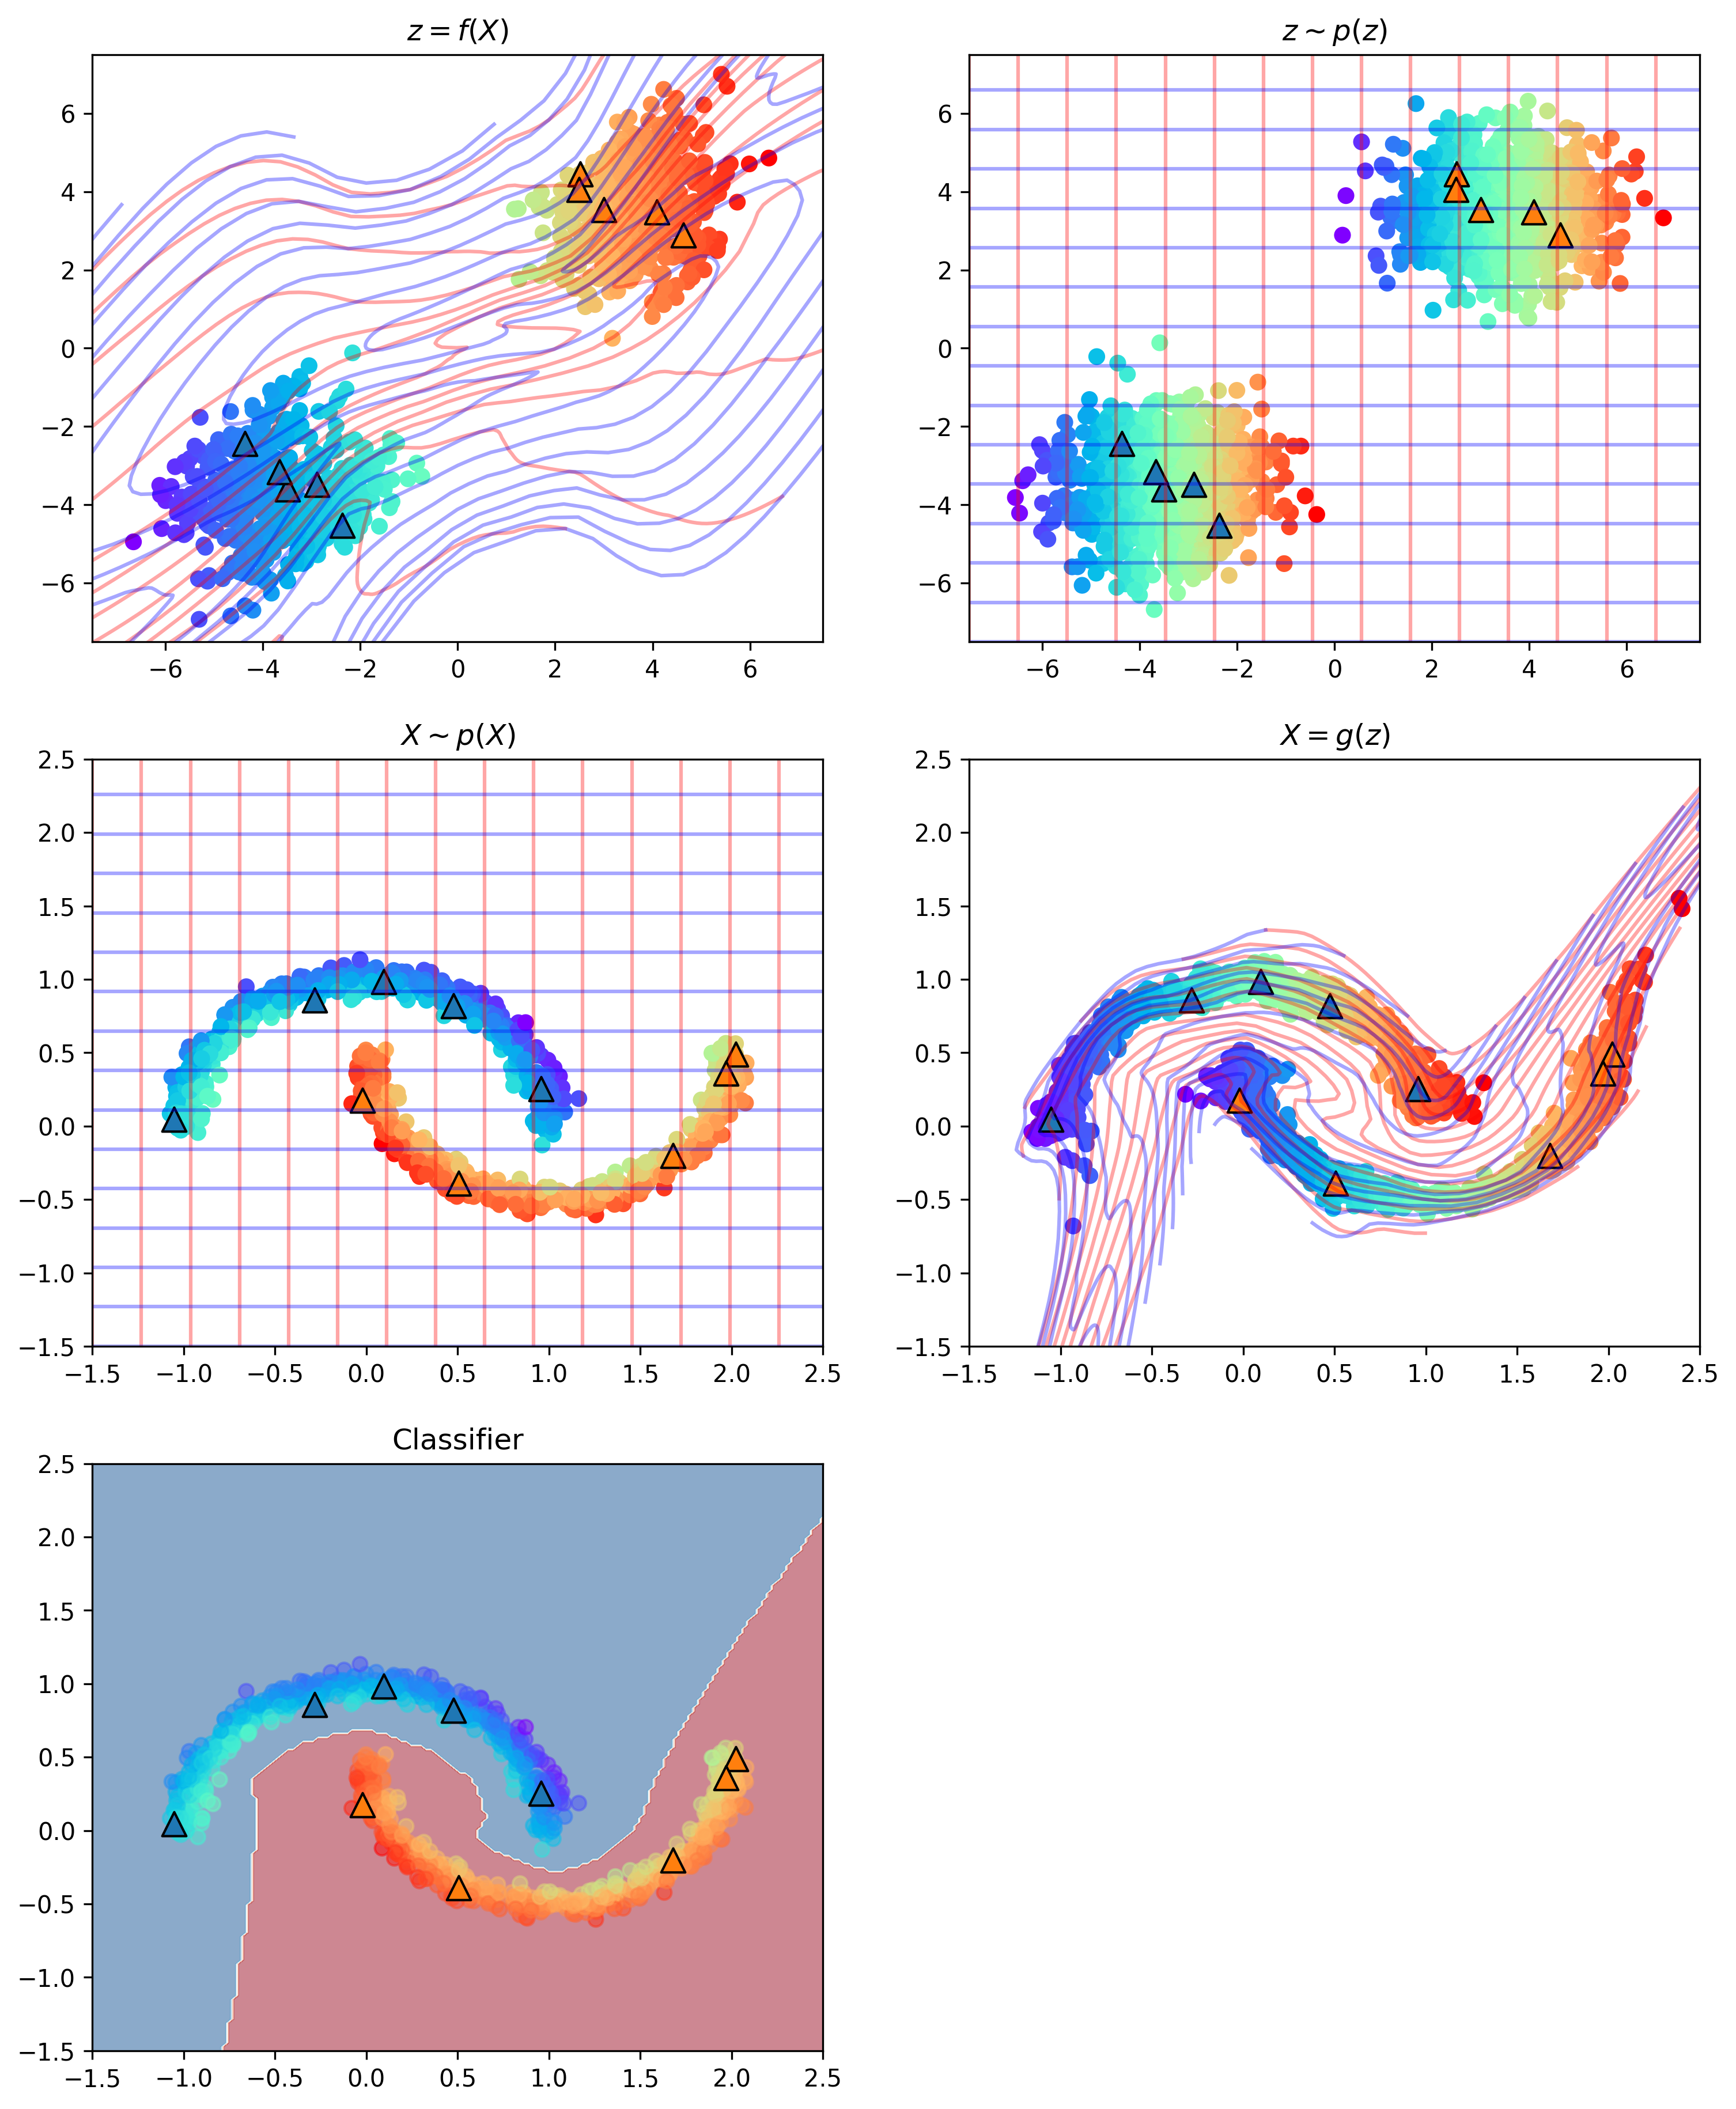

In [12]:
# Create a new figure with specified overall size.
plt.figure(figsize=(12, 15))

# ----------------------------------------------------------------
# Define grid parameters for visualization:
# - grid_points: number of grid points along each axis.
# - grid_freq: frequency to sample grid lines for plotting.
# - z_lims: limits in the latent space.
# - x_lims: limits in the input space.
grid_points = 150
grid_freq = 10
z_lims = np.array([-7.5, 7.5])
x_lims = np.array([-1.5, 2.5])

# Create 1D arrays for grid points in latent and input spaces.
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)

# Create meshgrids for latent space (xx_z, yy_z) and input space (xx_x, yy_x).
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)

# ----------------------------------------------------------------
# Compute the latent representation by passing data through the flow.
# 'data' is the original input data.
inv = flow(torch.from_numpy(data)).detach().numpy()

# ----------------------------------------------------------------
# Subplot (321): Plot latent representation z = f(X)
plt.subplot(321)
# Scatter plot latent space points.
# Here, we set colors using the first coordinate of z.
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
# For each class label, overlay markers for labeled data.
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
# Generate a grid in input space and transform it through the flow.
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
# Plot grid lines over the latent space.
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

# ----------------------------------------------------------------
# Subplot (322): Plot samples drawn from the Gaussian prior in latent space.
plt.subplot(322)
zs = []  # To store samples for each Gaussian component.
for i in range(len(means)):
    # Sample 1000 points from the i-th Gaussian.
    z_sample = loss_fn.prior.sample((1000,), gaussian_id=i).numpy()
    zs.append(z_sample)
    # Scatter plot the samples, using the first coordinate for the color.
    plt.scatter(z_sample[:, 0], z_sample[:, 1], c=z_sample[:, 0], cmap=plt.cm.rainbow)
# Plot grid lines over latent grid.
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
# Overlay the transformed training points for comparison.
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

# ----------------------------------------------------------------
# Subplot (323): Visualize original input space X.
plt.subplot(323)
# Scatter plot input data; here we use the latent first coordinate (inv[:,0])
# as a proxy color to show the learned transformation.
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
# Overlay labeled data points with markers.
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
# Plot grid lines in the input space.
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

# ----------------------------------------------------------------
# Subplot (324): Visualize the inverse mapping X = g(z)
plt.subplot(324)
# Apply the inverse flow on a grid from latent space.
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
# Plot grid lines showing the inverse mapping.
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []  # To store the inverse mapping for each Gaussian's samples.
# For each set of latent samples from the prior:
for z_sample in zs:
    # Map latent samples back to input space.
    x_inv = flow.inverse(torch.from_numpy(z_sample).float()).detach().numpy()
    # Scatter plot the inverse-mapped points.
    plt.scatter(x_inv[:, 0], x_inv[:, 1], c=x_inv[:, 0], cmap=plt.cm.rainbow)
    xs.append(x_inv)
# Overlay original labeled data for clarity.
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

# ----------------------------------------------------------------
# Subplot (325): Visualize the classifier decision boundary.
plt.subplot(325)
# Get decision boundary over the grid using the prior's classification.
classes = get_decision_boundary(f_xx, f_yy, prior)
# Plot a filled contour showing the decision regions.
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
# Overlay the original input data colored by the latent first coordinate.
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
# Overlay labeled data points with distinct markers.
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

# (Optional) Code to save the plot and data is commented out below:
# np.savez("../plots/data/toy_moons.npz", 
#          data=data, labels=labels, inv=inv,
#          xx_x=xx_x, yy_x=yy_x, xx_z=xx_z, yy_z=yy_z,
#          g_xx=g_xx, g_yy=g_yy, g_xx_=g_xx_, g_yy_=g_yy_,
#          f_xx=f_xx, f_yy=f_yy, f_xx_=f_xx_, f_yy_=f_yy_,
#          x_lims=x_lims, z_lims=z_lims,
#          x_lims_plot=x_lims, z_lims_plot=z_lims,
#          zs=zs, xs=xs,
#          classes=classes,
#         )

# Finally, display the figure.
plt.show()


In [1]:
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_moons_ssl, make_circles_ssl
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss



In [3]:
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_moons_ssl, make_circles_ssl
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss


In [5]:
import torch
import numpy as np
from flow_ssl.data import make_moons_ssl
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

# Generate toy moons dataset (SSL style: -1 for unlabeled, non-negative for labeled)
data, labels = make_moons_ssl()

# For simplicity, use only the labeled samples
data = data[labels != -1]
labels = labels[labels != -1]

# Convert to torch tensors
x = torch.from_numpy(data).float()
y = torch.from_numpy(labels).long()

# Set up the Gaussian Mixture Prior using two components
# Here, we use two components placed at (-3.5, -3.5) and (3.5, 3.5)
means = torch.tensor([[-3.5, -3.5], [3.5, 3.5]], dtype=torch.float)
prior = SSLGaussMixture(means=means)

# Create the flow model. Here we use RealNVPTabular for 2D inputs.
flow = RealNVPTabular(num_coupling_layers=5, in_dim=2, num_layers=1, hidden_dim=512)

# Initialize the loss function using the prior
loss_fn = FlowLoss(prior)

# Forward pass: transform input to latent space
z = flow(x)
# Get the log-determinant of the flow's Jacobian
sldj = flow.logdet()

# Compute loss (this combines the flow likelihood and supervised classification loss)
loss = loss_fn(z, sldj, y)

print("Initial loss:", loss.item())


Initial loss: 25.006723403930664


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/Users/daiziheng/Desktop/724/flowgmm-public/flow_ssl/distributions.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


Epoch 0: Loss = 24.8332
Epoch 500: Loss = 9.0847
Epoch 1000: Loss = 9.3937
Epoch 1500: Loss = 8.5524


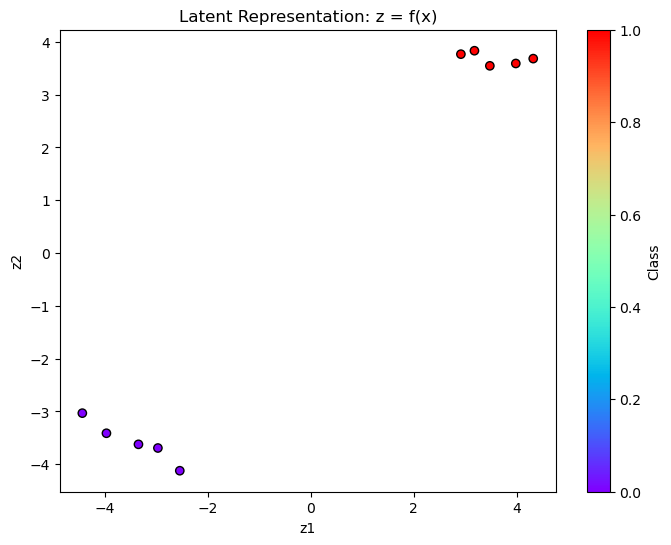

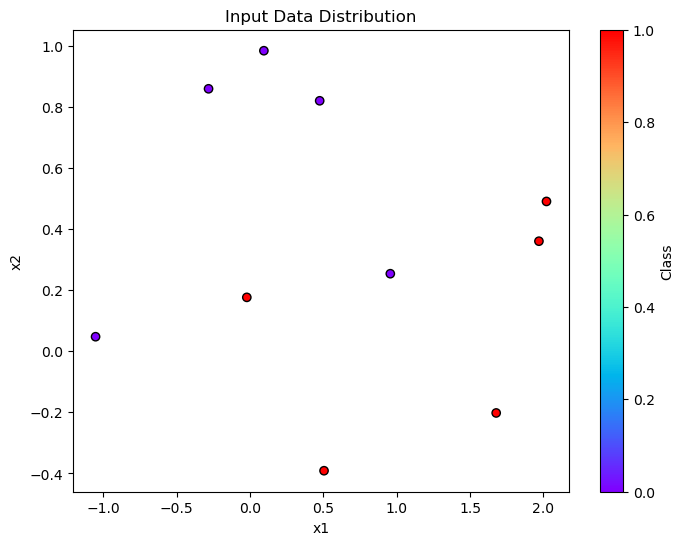

/Users/daiziheng/Desktop/724/flowgmm-public/flow_ssl/distributions.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


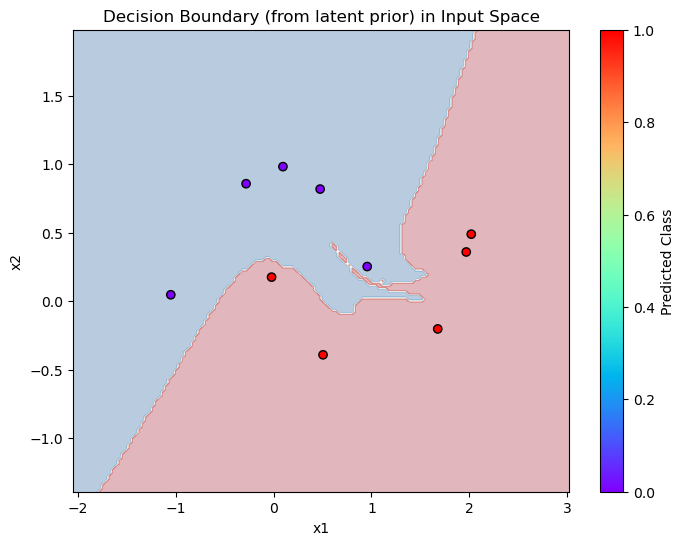

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Import FlowGMM components:
from flow_ssl.data import make_moons_ssl
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

# -------------------------------
# 1. Prepare the Data
# -------------------------------

# Create the toy moons dataset.
# The function make_moons_ssl() returns data and labels.
data, labels = make_moons_ssl()

# For simplicity, we use only labeled data (labels != -1).
data = data[labels != -1]
labels = labels[labels != -1]

# Convert to torch tensors.
x = torch.from_numpy(data).float()  # data input (shape: [N,2])
y = torch.from_numpy(labels).long()   # class labels

# -------------------------------
# 2. Define the Gaussian Mixture Prior
# -------------------------------

# Here we define two Gaussians in latent space.
# One is centered at (-3.5, -3.5) and one at (3.5, 3.5).
means = torch.tensor([[-3.5, -3.5], [3.5, 3.5]], dtype=torch.float)
prior = SSLGaussMixture(means=means)

# -------------------------------
# 3. Create the Flow Model
# -------------------------------

# For 2D inputs, we use RealNVPTabular.
# num_coupling_layers sets how many coupling steps we use.
flow = RealNVPTabular(num_coupling_layers=5, in_dim=2, num_layers=1, hidden_dim=512)

# -------------------------------
# 4. Define the Loss Function
# -------------------------------

# FlowLoss combines the likelihood loss and the supervised (classification) loss.
loss_fn = FlowLoss(prior)

# -------------------------------
# 5. Set Up the Optimizer and Training Loop
# -------------------------------
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4, weight_decay=1e-2)
num_epochs = 2000
print_freq = 500

for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Forward pass: map input to latent space.
    z = flow(x)
    # Obtain the log-determinant of the Jacobians.
    sldj = flow.logdet()
    # Compute loss: combines negative log-likelihood and (if applicable) classification loss.
    loss = loss_fn(z, sldj, y)
    loss.backward()
    optimizer.step()

    if epoch % print_freq == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# -------------------------------
# 6. Visualization
# -------------------------------

# Plot 1: Latent space representation
z_np = z.detach().numpy()  # latent codes from the training data
plt.figure(figsize=(8,6))
plt.scatter(z_np[:, 0], z_np[:, 1], c=y.numpy(), cmap='rainbow', edgecolors='k')
plt.title("Latent Representation: z = f(x)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.colorbar(label="Class")
plt.show()

# Plot 2: Original input space
plt.figure(figsize=(8,6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow', edgecolors='k')
plt.title("Input Data Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(label="Class")
plt.show()

# -------------------------------
# 7. (Optional) Plot a Decision Boundary
# -------------------------------
# This step demonstrates how the prior “classifies” points in latent space.
# We compute a grid of points in input space, transform them with the flow,
# and then have the prior assign a class to each transformed point.

# Create a grid over the input space.
grid_points = 150
x_min, x_max = data[:, 0].min()-1, data[:, 0].max()+1
y_min, y_max = data[:, 1].min()-1, data[:, 1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_points),
                     np.linspace(y_min, y_max, grid_points))
grid = np.hstack([xx.reshape(-1,1), yy.reshape(-1,1)])
grid_tensor = torch.from_numpy(grid).float()

# Apply the flow transformation to the grid points.
z_grid = flow(grid_tensor).detach()

# Use the prior classifier to get predicted class for each grid point.
# The prior has a method classify() that returns argmax over classes.
pred_classes = prior.classify(z_grid).numpy()
pred_classes = pred_classes.reshape(xx.shape)

# Plot decision boundary overlaying the original input scatter.
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, pred_classes, alpha=0.3, cmap='RdBu_r')
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow', edgecolors='k')
plt.title("Decision Boundary (from latent prior) in Input Space")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(label="Predicted Class")
plt.show()


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from flow_ssl.data import make_moons_ssl
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

# -------------------------------
# 1. Prepare Data (with unlabeled examples)
# -------------------------------
data, labels = make_moons_ssl()
x = torch.from_numpy(data).float()
y = torch.from_numpy(labels).long()

# -------------------------------
# 2. Prior and Model Setup
# -------------------------------
means = torch.tensor([[-3.5, -3.5], [3.5, 3.5]], dtype=torch.float)
prior = SSLGaussMixture(means=means)

flow = RealNVPTabular(num_coupling_layers=5, in_dim=2, num_layers=1, hidden_dim=512)
loss_fn = FlowLoss(prior)

optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4, weight_decay=1e-2)

# -------------------------------
# 3. Semi-Supervised Training Loop
# -------------------------------
epochs = 2000
print_freq = 500

for epoch in range(epochs):
    optimizer.zero_grad()
    z = flow(x)
    sldj = flow.logdet()
    loss = loss_fn(z, sldj, y)  # Handles both labeled and unlabeled
    loss.backward()
    optimizer.step()

    if epoch % print_freq == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 23.5239
Epoch 500 | Loss: 12.0190
Epoch 1000 | Loss: 11.9096
Epoch 1500 | Loss: 11.8625


In [11]:
print(f"Labeled points: {(y != -1).sum().item()}, Unlabeled points: {(y == -1).sum().item()}")


Labeled points: 10, Unlabeled points: 990


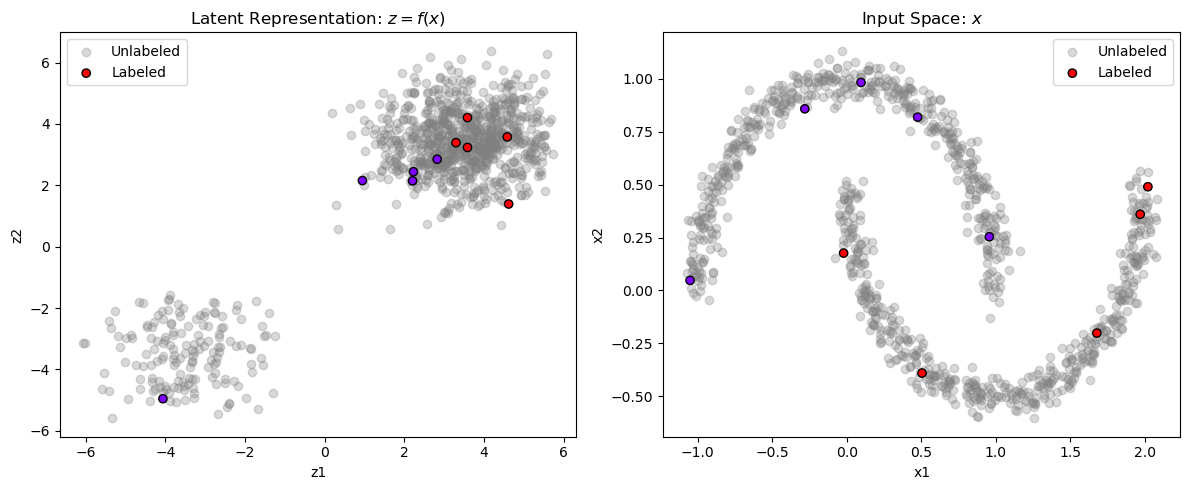

In [13]:
# ======================
# 1. Split out labeled data
# ======================
x_np = x.numpy()
y_np = y.numpy()
labeled_mask = y_np != -1
unlabeled_mask = y_np == -1

# ======================
# 2. Latent representation
# ======================
z_all = flow(x).detach().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(z_all[unlabeled_mask][:, 0], z_all[unlabeled_mask][:, 1], c='gray', alpha=0.3, label='Unlabeled')
plt.scatter(z_all[labeled_mask][:, 0], z_all[labeled_mask][:, 1], c=y_np[labeled_mask], cmap='rainbow', edgecolors='k', label='Labeled')
plt.title("Latent Representation: $z = f(x)$")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()

# ======================
# 3. Input space
# ======================
plt.subplot(1, 2, 2)
plt.scatter(x_np[unlabeled_mask][:, 0], x_np[unlabeled_mask][:, 1], c='gray', alpha=0.3, label='Unlabeled')
plt.scatter(x_np[labeled_mask][:, 0], x_np[labeled_mask][:, 1], c=y_np[labeled_mask], cmap='rainbow', edgecolors='k', label='Labeled')
plt.title("Input Space: $x$")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

plt.tight_layout()
plt.show()


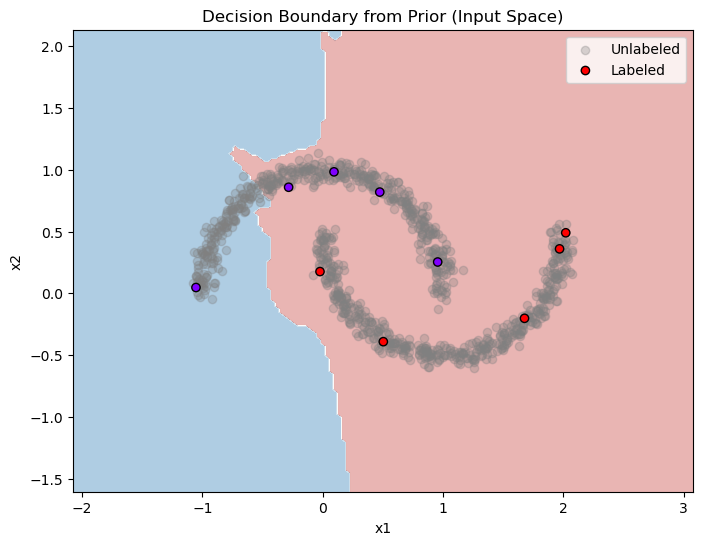

In [15]:
# ======================
# 4. Decision Boundary in Input Space
# ======================
grid_points = 150
x1_min, x1_max = x_np[:, 0].min() - 1, x_np[:, 0].max() + 1
x2_min, x2_max = x_np[:, 1].min() - 1, x_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, grid_points),
                     np.linspace(x2_min, x2_max, grid_points))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.from_numpy(grid).float()

# Map input grid to latent space
z_grid = flow(grid_tensor).detach()
pred_grid = prior.classify(z_grid).numpy().reshape(xx.shape)

# Plot boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_grid, levels=2, cmap="RdBu_r", alpha=0.4)
plt.scatter(x_np[unlabeled_mask][:, 0], x_np[unlabeled_mask][:, 1], c='gray', alpha=0.3, label='Unlabeled')
plt.scatter(x_np[labeled_mask][:, 0], x_np[labeled_mask][:, 1], c=y_np[labeled_mask], cmap='rainbow', edgecolors='k', label='Labeled')
plt.title("Decision Boundary from Prior (Input Space)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()
